In [1]:
import torch, time, pickle,os
import torch_geometric as tg
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os.path as osp
import networkx as nx

In [2]:
def convert(d,p):
    dfin=[]
    if len(p)!=len(np.unique(p)):
        print('Wrong order of prog/desc')
    else:
        no=d[0]
        for desc in d:
            if desc==no:
                dfin.append(0)
            else:
                dfin.append(p.index(desc)+1)
    return dfin, np.arange(1, 1+len(p))

In [3]:
medf=pickle.load(open(f'median_log10Mstellar_quantile.pkl', 'rb'))

In [4]:
def create_graphs(tcols=[0,2,4,5,6,7,8,10,28], target=8, lim=10.5, save=False, case='test', transform='quantile', maxs=[1,1,1]):
    dat=[]
    tcols=np.array(tcols)
    raw_path='~/../../../tigress/mcranmer/merger_trees/isotrees/'
    target_path='~/../../../tigress/mcranmer/merger_trees/samout/'
    transform_path=f'../../../../../scratch/gpfs/cj1223/GraphStorage/transformers/{transform}_allfeat.pkl'
    scaler=pickle.load(open(transform_path, 'rb'))
    not_include=np.array([0,1,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,0,0,0,0]) 
    is_cat=[0,1,0,1,1,1,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,\
        0,0,0,0,0,0,0,0,0,0,0]
    is_cat=np.array([bool(i) for i in is_cat])
    icols=np.array([1,3])
    load_cols=np.sort(np.concatenate([tcols,icols])) # maybe do np.unique
    not_include=not_include[load_cols]
    
    for i in range(0, maxs[0]):
        for j in range(0,maxs[1]):
            for k in range(0, maxs[2]):
                start=time.time()
                print(f'Loading isotree {i}_{j}_{k}')
                pd1=pd.read_table(raw_path+f'isotree_{i}_{j}_{k}.dat', skiprows=0, delimiter='\s+', usecols=load_cols)
                print(f'isotree {i}_{j}_{k} loaded, restructuring')
                
                raw=pd1.drop(axis=0, index=np.arange(50)).reset_index()
                del pd1
                
                trees=raw[raw.isna()['desc_id(3)']] 
                halos=raw[~raw.isna()['desc_id(3)']]
                del raw
                
                ##########################################
                ### End loading, begin dtype changing  ###
                ##########################################
                
                mask=halos.dtypes.values[1:]=='O'

                f,it="float64", "int64"
                map1=[]
                map2=[]
                q=0
                for l in load_cols:
                    q+=1
                    if l<25:
                        map1.append(l)
                        map2.append(q)
                map1=np.array(map1)
                map2=np.array(map2)

                castto=np.array([f,it,f,it,it,it,it,it,it,f,f,f,f,f,it,f,f,f,f,f,f,f,f,f,f])

                castto=castto[map1]
                dicts = {}
                keys = halos.columns[map2]
                for d, key in enumerate(keys):
                        dicts[key] = castto[d]

                halos=halos.astype(dicts)
                
                ###################################################
                ### end dtype, begin inital hardcoded scaling   ###
                ###################################################
                
                ## initial scaling
                hard=[0,2,15]
                def logit(x):
                    return np.log10((x+0.001)/(1.01-x))
                ##logit transform the hards
                for h in hard:
                    if h in tcols:
                        h1=np.where(load_cols==h)[0][0]+1
                        halos[halos.columns[h1]]=logit(halos[halos.columns[h1]])

                log=[10,38, 39, 40, 41, 42]
                #simple log for the rest
                def logt(x):
                    return np.log10(x+1)
                for l in log:
                    if l in tcols:
                        l1=np.where(load_cols==l)[0][0]+1
                        halos[halos.columns[l1]]=logt(halos[halos.columns[l1]])

                scale_cols=np.array(tcols[~is_cat[tcols]])

                print(f'Splitting to tree and scaling')
                spli=np.split(np.array(halos)[:,1:], np.array(trees.iloc[1:].index)-np.arange(1,len(trees.index)))
                del halos
                splits=[]
                for s in spli:
                    if s[0,np.where(load_cols==10)[0][0]]>lim:
                        splits.append(s)
                splits=np.array(splits, dtype=object)
                split=[]
                
                for tree in splits:
                    s=tree[np.logical_or(tree[:,3] == -1,tree[:,4]!=1)]
                    for n in scale_cols:
                        n1=np.where(load_cols==n)[0][0]
                        s[:,n1]=scaler[n].transform(s[:,n1].reshape(-1,1)).reshape(np.shape(s[:,n1]))
                    split.append(s)
                split=np.array(split, dtype=object)
                print('Split done')
                print('Loading targets')
                ex=f'{i}_{j}_{k}/galprop_0-99.dat'
                pdc=pd.read_table(target_path+ex, skiprows=0, delimiter=',', nrows=41, header=None)
                newcols=pdc.iloc[:,0]
                pds=pd.read_table(target_path+ex, skiprows=41, delimiter='\s+', header=None)
                pds.columns=np.array(newcols)
                pd0=pds[pds[pds.columns[3]]==0.00] # subhaloes
                pdcen=pd0[(pd0[pds.columns[1]]==pd0[pds.columns[2]])] ##central haloes

                rhalid=np.array(pdcen[pds.columns[2]])
                del pd0
                del pds
                halwgal=[]
                ids=[]
                out=[]
                M_h=[]
                for idx, tree in enumerate(split): #split up into tree
                    if tree[0,1] in rhalid:
                        if len(tree)>20000:
                            print(len(tree))
                        else:
                            M_h.append(tree[0,np.where(load_cols==10)[0][0]])
                            halwgal.append(tree)
                            ids.append(idx)
                            index=np.where(rhalid==tree[0,1])
                            out.append(np.array(pdcen.iloc[index])[0][target]) ## target variable
                del pdcen
                M_h=np.array(M_h)
                hraw=np.array(splits[ids], dtype=object)
                hals=[]
                pr,de=[],[]
                discards=[]
                print('Making merger tree')
                for n in tqdm(range(len(halwgal))):
                    h=halwgal[n]
                    roots=h[h[:,4]==0]
                    mergers=h[h[:,4]>1]
                    final=h[h[:,3]==-1]
                    pro, des=[],[]
                    discarded=[]
                    for mid in mergers[:,1]:
                        k=1
                        descid=hraw[n][:,3][np.where(mid==hraw[n][:,1])] ##descendant ID of raw where the id of the merger is
                        while descid not in mergers[:,1] and descid!=-1: 
                            k+=1
                            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]
                        pro.append(mid)
                        if descid!=-1:
                            des.append(descid[0])
                        else:
                            des.append(hraw[n][:,3][np.where(mid==hraw[n][:,1])][0])
                        discarded.append(1/k) 

                    for r in roots:
                        descid=hraw[n][:,3][np.where(r[1]==hraw[n][:,1])] 
                        k=1
                        while descid not in mergers[:,1] and descid!=[-1]: ##could add 1/k
                            k+=1
                            descid=hraw[n][:,3][np.where(descid==hraw[n][:,1])]#consider adding the number of steps it went through
                        pro.append(r[1])
                        if descid!=-1:
                            des.append(descid[0])
                        else:
                            des.append(hraw[n][:,3][np.where(r[1]==hraw[n][:,1])][0])
                        discarded.append(1/k) 

                    discards.append(np.array(discarded))
                    des,pro=convert(des, pro)
                    hal2=np.vstack([final,mergers,roots])
                    global mass_index
                    if n==0:
                        fcols=[i for i in range(len(hal2[0])) if not_include[i]==0] ##choose non-id cols to carry forward
                        mask=np.array([bool(i) for i in not_include])
                        idcols=load_cols[~mask] ##choose non-id cols to carry forward
                        mass_id=np.where(np.array(idcols)==10)[0][0]
                    hal2=hal2[:,fcols] ##take away id's
                    hals.append(hal2)
                    pr.append([int(p) for p in pro])
                    de.append([int(d) for d in des])
                    discards.append(discarded)
                hals=np.array(hals,dtype=object)
                
                ##here we make the scatter
                M_s=np.log10(out)
                out=M_s-medf(M_h)
                for n in tqdm(range(len(out))):
                    edge_index = torch.tensor([pr[n],de[n]], dtype=torch.long)
                    x = torch.tensor(hals[n], dtype=torch.float)
                    y=torch.tensor(out[n], dtype=torch.float)
                    edge_attr=torch.tensor(discards[n], dtype=torch.float)
                    graph=Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
                    dat.append(graph)
                stop=time.time()
                print(f'Done with tree. \n Time elapsed {stop-start} s')
    
    if save:
        print("Saving dataset")
        if not osp.exists(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}'):
            os.mkdir(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}')

        with open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'wb') as handle:
            pickle.dump(dat, handle)


    return dat

In [5]:
all_cols=np.array([0,2,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,35]+list(range(37,60)))
# all_cols=np.array([0,2,4,6,7,8,10,11,12,13,14,15,16,17,18,19,22,23,25,35]+list(range(37,60)))

dat=create_graphs(tcols=all_cols, maxs=[1,2,2], lim=10, save=1, case='med_all_residual')

Loading isotree 0_0_0


/tmp/ipykernel_29286/26384137.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[1,2,2], lim=10, save=1, case='med_all_residual')


isotree 0_0_0 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
Making merger tree


100%|███████████████████████████████████████████████████████████| 769/769 [00:00<00:00, 4565.71it/s]


Done with tree. 
 Time elapsed 289.05513310432434 s
Loading isotree 0_0_1


/tmp/ipykernel_29286/26384137.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[1,2,2], lim=10, save=1, case='med_all_residual')


isotree 0_0_1 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
Making merger tree


100%|█████████████████████████████████████████████████████████| 1338/1338 [00:00<00:00, 4400.70it/s]


Done with tree. 
 Time elapsed 703.2840404510498 s
Loading isotree 0_1_0


/tmp/ipykernel_29286/26384137.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[1,2,2], lim=10, save=1, case='med_all_residual')


isotree 0_1_0 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
70472
Making merger tree


100%|█████████████████████████████████████████████████████████| 1127/1127 [00:00<00:00, 4369.03it/s]


Done with tree. 
 Time elapsed 487.38381361961365 s
Loading isotree 0_1_1


/tmp/ipykernel_29286/26384137.py:4: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types.Specify dtype option on import or set low_memory=False.
  dat=create_graphs(tcols=all_cols, maxs=[1,2,2], lim=10, save=1, case='med_all_residual')


isotree 0_1_1 loaded, restructuring
Splitting to tree and scaling
Split done
Loading targets
70115
52207
43321
25280
381538
Making merger tree


100%|█████████████████████████████████████████████████████████| 1932/1932 [00:00<00:00, 4509.59it/s]


Done with tree. 
 Time elapsed 992.4761333465576 s
Saving dataset


In [8]:
Ms, ys, ls=[],[],[]
for d in dat:
    ys.append(d.y.numpy())
    Ms.append(d.x.numpy()[0,3])    
    ls.append(len(d.x.numpy()))    

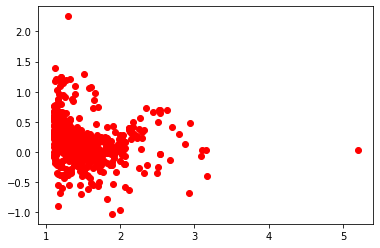

In [9]:
plt.plot(Ms,ys,'ro')